In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder
from PIL import Image, ImageEnhance
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
import sys
sys.path.insert(0, os.path.abspath(config['lib']))
import final_model_functions as f

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

## Run the following cells to download the database and extract it automatically on data/raw

In [ ]:
try:
    os.mkdir(config['data']['raw'])
except:
    print('Error - folders not created')

In [ ]:
url = 'https://drive.google.com/uc?id=1ZwTbaZwJYs0b20wtdpNYWZrOWvDo0FQD'
output = config['data']['raw']+'brain_tumor_dataset.zip'
unzip = config['data']['raw']
gdown.download(url, output, quiet=False)
shutil.unpack_archive(output, unzip)
os.remove(output)

## Setting the paths, visualize some pics

In [2]:
train_dir = config['data']['raw']+'Training/'
test_dir = config['data']['raw']+'Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

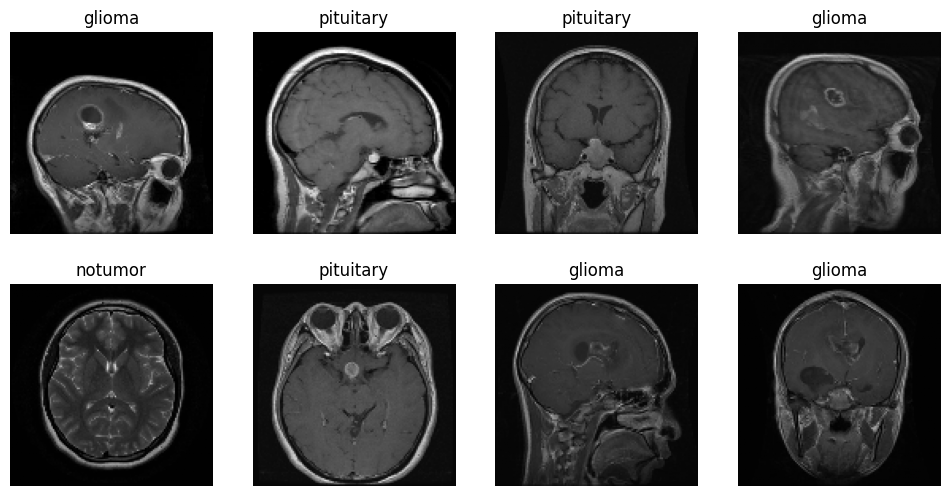

In [3]:
images = f.open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Label encoding and generating arrays

In [4]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = f.open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

## Creating the model

In [5]:
#Import VGG16 - Very Deep Convolutional Networks for Large-Scale Image Recognition
base_model = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg16 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential(name='Brain_Tumor_Scanner')
model.add(Input(shape=(128,128,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [6]:
model.summary()

Model: "Brain_Tumor_Scanner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,12

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
final_model_mcp = ModelCheckpoint(filepath = config['models']+'final_model_weights.h5', monitor = 'sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 2)
final_model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 2, verbose = 1)


history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, callbacks=[final_model_mcp, final_model_es])

Epoch 1/10
285/285 [==============================] - ETA: 0s - loss: 0.4562 - sparse_categorical_accuracy: 0.8212
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.82123, saving model to ../models/final_model_weights.h5
285/285 [==============================] - 287s 1s/step - loss: 0.4562 - sparse_categorical_accuracy: 0.8212
Epoch 2/10
285/285 [==============================] - ETA: 0s - loss: 0.2322 - sparse_categorical_accuracy: 0.9123
Epoch 2: sparse_categorical_accuracy improved from 0.82123 to 0.91233, saving model to ../models/final_model_weights.h5
285/285 [==============================] - 286s 1s/step - loss: 0.2322 - sparse_categorical_accuracy: 0.9123
Epoch 3/10
 66/285 [=====>........................] - ETA: 3:38 - loss: 0.1961 - sparse_categorical_accuracy: 0.9215

In [ ]:
model.save(config['models']+'model.model')

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

## Model evaluation

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
m_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
display_cm = ConfusionMatrixDisplay(cm, display_labels=m_labels)
display_cm.plot()
plt.tight_layout()

plt.savefig(config['pics']+'confusion_matrix.png', bbox_inches='tight')

## Predictions

In [ ]:
def conclusion(number):
    if number==2:
        return 'Tumor - Glioma'
    elif number ==0:
        return 'Tumor - Meningioma'
    elif number == 3:
        return 'Not a tumor'
    elif number == 1:
        return 'Tumor - pituitary'
    else:
        return 'Sorry, not clear'

In [ ]:
image = config['data']['raw']+'Testing/notumor/Te-no_0052.jpg'

In [ ]:
img = Image.open(image)
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(conclusion(classification))

In [ ]:
image = config['data']['raw']+'Testing/meningioma/Te-me_0015.jpg'

In [ ]:
img = Image.open(image)
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(conclusion(classification))

In [ ]:
image = config['pics']+'pituitary1.jpg'

In [ ]:
img = Image.open(image)
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(conclusion(classification))

In [ ]:
image = config['data']['raw']+'Testing/glioma/Te-gl_0036.jpg'

In [ ]:
img = Image.open(image)
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(conclusion(classification))